In [28]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import os 
import sys
#import seaborn as sns
import random
import names

random.seed(20)

import time 
import datetime 


print(sys.version_info)

for module in mpl, np, pd, sklearn, names:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.18.1
pandas 0.24.2
sklearn 0.21.3
names 0.3.0


# Bus
This a class for bus objects

In [2]:
def time_str_to_seconds(time_str):
    x = time.strptime(time_str.split(',')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

def time_seconds_to_str(cur_time):
    str_time = str(datetime.timedelta(seconds=cur_time))
    #print(str_time)
    return str_time

def pprint(cur_time, strs, ending = False):#
    """just a print function with time"""
    if ending:
        print('[{}]: {}'.format(time_seconds_to_str(cur_time),strs), end = '')
    else:
        print('[{}]: {}'.format(time_seconds_to_str(cur_time),strs))
from IPython.core.debugger import set_trace


class Bus(object):
    
    seats = 15
    def __init__(self, 
                 index,
                 route_obj,
                 route,
                 max_battery=15000, #
                 size=15,
                 pos=0.0,
                 consume_rate = 2, #
                 charge_speed = 8): #
        
        self.index = index
        self.route_obj = route_obj
        self.route = route
        self.pos = 0
        self.size = size
        
        self.operate = False 
        self.charge_complete = True
        self.consume_rate = consume_rate
        self.charge_speed = charge_speed
        
        self.run_time = 0

        
        self.passengers = []
        self.total_passengers = 0
        
        self.max_battery = max_battery
        self.current_battery = max_battery
        
        self.stop = False
        
    @property
    def free_seats(self):
        return self.size - len(self.passengers)
    
    def take_in(self, cur_time, passengers):
        """take in passengers"""
        len_pass_before = len(self.passengers)
        self.passengers.append(passengers)
        self.total_passengers += 1
        
        return len(self.passengers)
            
    def get_off(self, station_index, cur_time):
        """
        Passenger arrives destination and leaves the bus.
        """
        len_pass_before = len(self.passengers)
        out_passengers = [passenger for passenger in self.passengers
                          if passenger.destination == station_index]

        for passenger in out_passengers:
            passenger.end_time = cur_time
            self.passengers.remove(passenger)
            
        pprint(cur_time, "Bus {} at {} having {}/{} passengers deboarding".format(self.index, 
                                                                               self.route[self.pos], 
                                                                               len(out_passengers),
                                                                               len_pass_before))
        return out_passengers  
        
            
    def terminal(self, cur_time, stop_time):
        """
        This function is called when the bus reaches the last stop.  All the
        passengers get out of the bus.
        Returns
        -------
        """
        self.passengers = []
        temp_route = self.route.copy()
        temp_route.reverse()

        self.route = temp_route.copy() #reverse route 
        pprint(cur_time, "Bus {} is going to run a reversed route {}".format(self.index, self.route))     

        self.run_time =0
        self.pos = 0
        self.operate = False
        self.to_stop(cur_time, stop_time)
    
        return True
        
    def is_battery_enough(self):
        """
        This is a function to check if the bus' battery is enough for the next
        run. Determined by consume_rate*route_distance and battery left.
        """
        distance =  self.route_obj.calculate_all_dist()
        if self.consume_rate * distance < self.current_battery:
            return True
        else:
            return False
        
    def charge(self):
        """
        simulate charging battery
        
        """
        if self.current_battery < self.max_battery:
            self.current_battery += self.charge_speed   #battery unit/sec
            return False
        else:
            return True
        
        
    def to_operate(self,cur_time, stop_time, bus_station_list):
        """To opereate a bus"""
        
        if not self.stop: #if the stop sign is False

            if not self.operate:
                #print(self.charge_complete, self.pos)
                if self.charge_complete and self.pos==0:
                    #starting from terminals with full battery, take in all passengers
                    for station in bus_station_list:
                            if station.index == self.route[self.pos]:
                                station.dequeue_to_bus(cur_time, self) 
                    self.operate = True


            if self.route[self.pos]== self.route[0]:
                if not self.is_battery_enough():
                    self.operate = False
                    self.charge_complete = self.charge()
                    if cur_time % 60 ==0:
                        pprint(cur_time, "Bus {} is charging at station {}".format(self.index, self.route[0]))

                elif self.current_battery >= self.max_battery and not self.operate :
                    self.operate = True
                    pprint(cur_time, "Bus {} charge complete at station {}".format(self.index, self.route[0]))

                elif not self.charge_complete:
                    self.charge_complete = self.charge()
                    if cur_time % 60 ==0:
                        pprint(cur_time, "Bus {} is charging at station {}".format(self.index, self.route[0]))

            if self.operate == True:

                self.run_time +=1
                self.current_battery-= self.consume_rate

                if len(self.route) == 2: 

                    #print(self.route_obj.calculate_two_dist(self.route[0], self.route[1]), self.run_time)

                    if self.route_obj.calculate_two_dist(self.route[0], self.route[1]) == self.run_time:
                        self.run_time = 0
                        #print("Bus {} reaches a terminal {}".format(self.index, self.route[1] ))
                        self.pos += 1 
                        pprint(cur_time, "Bus {} arrives at terminal {}".
                               format(self.index, self.route[self.pos]))
                        for station in bus_station_list:
                            if station.index == self.route[self.pos]:
                                pprint(cur_time, "Bus {}  arrives at stop {}".format(self.index, 
                                                                                     self.route[self.pos]))
                                get_off_passengers = self.get_off(station.index, cur_time)
                                station.arrival_list.extend(get_off_passengers)
                                self.terminal(cur_time, stop_time)



                elif len(self.route) > 2: 

                    if self.route_obj.calculate_two_dist(self.route[self.pos], 
                                                          self.route[self.pos+1]) == self.run_time:
                        self.pos += 1
                        self.run_time = 0
                        #print("*bus {} is at postion {}".format(self.index, self.pos))
                        for station in bus_station_list:
                            if station.index == self.route[self.pos]:
                                pprint(cur_time, "Bus {} arrives at stop {}".format(self.index, 
                                                                                     self.route[self.pos]))
                                get_off_passengers = self.get_off(station.index, cur_time)
                                station.arrival_list.extend(get_off_passengers)
                                if self.route[self.pos]== self.route[-1]:
                                    self.terminal(cur_time, stop_time)
                                    pprint(cur_time, "Bus {} arrives at terminal {}".
                                           format(self.index, self.route[self.pos]))
                                else:
                                    station.dequeue_to_bus(cur_time, self) 

                else:
                    print('route length', len(self.route))
                    print('BUS {}, at pos {}, with route {}'.format( self.index, self.pos, self.route))
                    print('route length', len(self.route))
                    raise ValueError('not enough stations in a route')



                            
        return self.index
        
    def to_stop(self, cur_time, stop_time):
        
        time_one_run =  self.route_obj.calculate_all_dist()
        time_before_stop = stop_time - cur_time
        if time_one_run + 5 > time_before_stop:
            self.stop = True
            print("Bus {} terminates...".format(self.index))
        
        return self.stop
        

In [3]:
print("Errr...")

Errr...


# Route
Route determines which route the buses should follow.


In [4]:
# Bus class
class Route:
    def __init__(self, route_num):
        self.route_num = route_num
        self.route_list = [['A', 'E', 'F'], ['A', 'B', 'C'] , ['A', 'D'], ['B', 'E', 'F'] , ['D', 'E', 'F'] ]
        self.route = self.route_list[self.route_num] #inital route by givn route number 0-4
        self.route_bus_limit = [3,3,2,2,2]
                
        self.bus_list = []
        self.time_unit = 60
        self.station_dist_graph = {'A':{'B':10*self.time_unit, 'E':25*self.time_unit, 'D':35*self.time_unit},
                                   'B':{'A':10*self.time_unit, 'C':15*self.time_unit, 'E':15*self.time_unit},
                                   'C':{'B':15*self.time_unit},
                                   'D':{'A':35*self.time_unit, 'E':15*self.time_unit},
                                   'E':{'A':25*self.time_unit, 'B':15*self.time_unit, 
                                        'D':15*self.time_unit, 'F':15*self.time_unit},
                                   'F':{'E':15*self.time_unit}}
        
        
        
    def calculate_all_dist(self):
        """
        calculate distances by adding all the distances between each node(station).
        
        currently, distance represents time(minutes).
        """
        dist = 0 
        for v, w in zip(self.route[:-1],self.route[1:]):
            dist += self.station_dist_graph[v][w]
        return dist
    
    def calculate_two_dist(self, station1, station2):
        """calcualte distance/time between two stops"""
        dist = self.station_dist_graph[station1][station2]
        return dist
    
    
    def run_all_bus(self):
        """peform bus operations in this route"""
        for bus in self.bus_list:
            bus.to_operate()
    
    def generate_bus(self):
        if  len(self.bus_list) >= self.route_bus_limit[self.route_num]:
            #print("failed to add bus due to route {} bus number limitation {}...".
            #      format(self.route_num+1, self.route_bus_limit[self.route_num]))
            return False
        else: 
            bus_index = (self.route_num+1)*10 + len(self.bus_list)+1
            bus = Bus(index=bus_index,
                      route_obj=self,
                      route=self.route)
            self.bus_list.append(bus)
            #print("bus {} route {} created.".format(bus.index, bus.route))
            return True
        
r1 = Route(0)
print('route no.0:', r1.route)
r1.route.reverse()
print('reversed route:',r1.route)
print("route distance", r1.calculate_all_dist())

r_list = []
for i in range(5):
    r_list.append(Route(i))
    for j in range(3):
        r_list[i].generate_bus()
b_list = [r.bus_list for r in r_list]


print(r1.route[0])

route no.0: ['A', 'E', 'F']
reversed route: ['F', 'E', 'A']
route distance 2400
F


# Passenger class

In [5]:
class Passenger:
    """
    Passenger class is a object for storing passenger basic information inlcuding
    the waiting time, 
    """
    def __init__(self, origin, destination, start_time):
        self.origin = origin
        self.destination = destination
        self.start_time = start_time
        self.end_time = None
        self.time_waited_for_bus = 0
        self.bus_index = None
        self.get_name = self.get_name()
        self.name = self.get_name
        

    def get_name(self):
        return names.get_full_name()
    
    def travel_time(self):
        return self.end_time - self.start_time
    
    """        
    def wait_time(self, cur_time):
        if self.location == 0:
            return  cur_time - self.dep_time
        else:
            raise "warning pasenger not at station!"
    def boarding(self, bus):
        if self.location != 0 :   
            raise "warning pasenger not at station!"
        else: 
            self.location = 1
            self.bus = bus
    def status():
        print('Passenger')
    """
            
p1 = Passenger('A', 'F',  '08:00:00')
p1.name

'Christopher Wicks'

## Station class
station can represents as a queue of passengers


In [6]:
class Station:
    def __init__(self,  index = ''):
        self.passengers = []
        self.index = index
        self.arrival_list = [] 
        self.last_dep_time = None
        
        
    def enqueue(self,cur_time, destination):
        """
        When a passenger arrives, add him/her to the queue.
        This function is the function to generate passenger objects.
        
        """
        passenger = Passenger(origin=self.index,
                              destination=destination,
                              start_time=cur_time)
        self.passengers.append(passenger)
        return passenger
        
    def dequeue_to_bus(self, cur_time, bus):
        """
        When a bus comes, check if the passenger's destination on the bus' not arrived station list,
        following a first come first serve rule to get on bus. Put the passengers who want
        to get on the bus in a pop(wait) list. Calculate the bus capacity and pop list to check how many
        passengers to pop. In another word, pop passengers to bus following the minumum of bus capacity or 
        wait list length.
        
        Arguments
        ---------
        cur_time: float
        pop_list: list of passenger index in station who want to get on the bus. 
        bus: the bus arrived.
        
        Returns
        -------
        nb_to_bus: number of passengers get on the bus.
        """
        
        self.last_dep_time = cur_time
        
        if len(self.passengers) < 1:
            return None

        pop_list = []
        for i in range(len(self.passengers)):
            if self.passengers[i].destination in bus.route[bus.pos+1:]:
                pop_list.append(i)   
                
        nb_to_bus = min(bus.free_seats, len(pop_list))  
        pprint(cur_time, 'Station {} receives bus {}: {} people want get on,'
               ' {} available seats'.format(self.index, bus.index, len(pop_list), bus.free_seats))
        if len(pop_list ) == 0:
            pprint(cur_time,'non poplist to onboarding...')
            return 0
        
        for i in range(nb_to_bus):
            passenger = self.passengers.pop(pop_list[0])
            pop_list.pop(0)
            pop_list = [x - 1 for x in pop_list]
            passenger.time_waited_for_bus = cur_time - passenger.start_time 
            passenger.bus_index = bus.index
            bus.take_in(cur_time,passenger)
            
         
        return nb_to_bus
    
    def dequeue_to_walk(self, cur_time, max_wt):
        """
        Dequeue passengers whose waiting time exceeds the maximum wait time threshold. Adds them to a walk list.
        
        Arguments
        ---------
        cur_time: float
        pop_list: list of passenger index in station whose waiting time exceeds the maximum wait time threshold.
        walk_list: list of passenger who choose to to walk globally.
        
        Returns
        -------
        walk_list: updated list of passenger who choose to to walk globally.
        """
        walk_list = []
        pop_list = []
        
        
        for i in range(len(self.passengers)):
            if (cur_time - self.passengers[i].start_time) > max_wt:
                pop_list.append(i)
                self.passengers[i].time_waited_for_bus = cur_time - self.passengers[i].start_time 
                walk_list.append(self.passengers[i])
        
        self.passengers = [p for i,p in enumerate(self.passengers) if i not in pop_list]
        
        
        #pprint(cur_time, '*At Station {}, {} people feel '
        #       'unsatisfied of the sevice and choose to walk. {} people still waiting'.format(self.index,
        #                                                len(pop_list), len(self.passengers)))
        return walk_list
            
    def size(self):
        """returns the station's waiting length"""
        return len(self.passengers) 

    

In [7]:
import numpy as np
np.random.random()

0.7487281245586617

# Passenger demand
Make two distrubution of passengers, with guassian distribution 

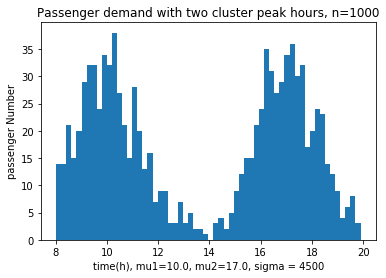

In [8]:
def passenger_demand(demand, sigma , start, end):
    """
    Make two distrubution of passengers, with guassian distribution
    """
    #np.random.seed(42) # force repeatable random seeds
    
    mu1 = 10*3600
    mu2 = 17*3600

    n1 = np.random.normal(mu1, sigma, int(demand/2))
    n2 = np.random.normal(mu2, sigma, int(demand/2))

    passenger_dist = np.round(np.hstack((n1,n2)))
    for i in range(len(passenger_dist)):
        if passenger_dist[i] < start or passenger_dist[i] >= end:
            passenger_dist[i] = int(start + (np.random.random() * (end - start)))
            
    s = passenger_dist/3600
    count, bins, ignored = plt.hist(s, 60, density=False)
    plt.title("Passenger demand with two cluster peak hours, n={}".format(demand))
    plt.xlabel("time(h), mu1={}, mu2={}, sigma = {}".format(mu1/3600,mu2/3600,sigma))
    plt.ylabel("passenger Number")
    plt.savefig('passenger_dist.png', dpi = 300)
    return passenger_dist

def passenger_demand_noplot(demand, sigma , start, end):
    """
    Make two distrubution of passengers, with guassian distribution
    """
    #np.random.seed(42) # force repeatable random seeds
    
    mu1 = 10*3600
    mu2 = 17*3600

    n1 = np.random.normal(mu1, sigma, int(demand/2))
    n2 = np.random.normal(mu2, sigma, int(demand/2))

    passenger_dist = np.round(np.hstack((n1,n2)))
    for i in range(len(passenger_dist)):
        if passenger_dist[i] < start or passenger_dist[i] >= end:
            passenger_dist[i] = int(start + (np.random.random() * (end - start)))

    return passenger_dist



passenger_dist = passenger_demand(demand=1000, sigma = 4500, start = 8*3600, end=20*3600)

In [9]:
from contextlib import contextmanager
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Simulation

In [10]:
global time_coef, passenger_dist
time_coef = 100000000
      

class Simulation:
    """
    This class defines all the simulation operations including random generate bus, 
    bus interval; generate passenger/interval randomly at each station with random
    routes, etc.
    
    Simulation world runs on a simulation time series with a time coeficent parameter
    "time_coef", which determines to how many times faster than real world. 
        
    """
    def __init__(self,
                 passenger_dist, 
                 bus_stations_index=['A', 'B', 'C', 'D', 'E', 'F'],
                 route_bus_limit= [3,3,2,2,2],
                 init_time = '08:00:00',
                 stop_time = '20:10:00',
                 bus_start_interval = 5,
                 gen_bus_interval = 20
                 ):
        
        self.passenger_dist = passenger_dist
        self.init_time = init_time
        self.stop_time = stop_time
        self.bus_start_interval = 60*bus_start_interval
        
        self.bus_stations_index = bus_stations_index
        
        self.bus_stations = self.gen_bus_stations()
        self.gen_bus_interval = 60* gen_bus_interval   #generate bus every xx minutes
        
        self.route_list = self.generate_route()
        self.route_bus_limit = route_bus_limit
        

        #
        #self.gen_passenger_interval = 60*5 #generate passengers every 60*n seconds
        #self.max_gen_passenger_number = 20 #random generate 0-n passengers
        #self.gen_passenger = True
        
        self.walk_list = []
        self.max_wt = 60*30 #
    
        self.station_check_interval = 60*15 #how long time to check station status, if people waited too long time
        
        self.arrivals = []
        


    def gen_bus_stations(self):
        bus_station_list = []
        try:
            for i in self.bus_stations_index:
                station = Station(index = i)
                bus_station_list.append(station)
            print('Bus station generated: ',[i.index for i in bus_station_list])
        except TypeError as te:
            print(self.bus_stations_index)
            raise TypeError
        return bus_station_list
    
    def arrival_list_sum(self):
        arrives = {}
        for s in self.bus_stations:
            self.arrivals.extend(s.arrival_list)
            arrives[s.index] = s.arrival_list.copy()
            s.arrival_list = []
        return arrives
    
    
    def generate_route(self):
        """generating routes following route table in class Route, i is the route number"""
        print("generating routes")
        return  [Route(i) for i in range(5)]
    
  

    def add_bus(self, route_num, cur_time):
        """
        generate bus for each route
        ------
        if (current time - last departure bus time in this station) < interval
            return False -> postpone bus departure time for 5 mins
        otherwise generate bus
        
        """
        route = self.route_list[route_num]
        for station in self.bus_stations:
            if station.index == route.route[0]:
                #check time interval betwee two buses, if TypeError, it indicates no bus come before
                #will start a bus at this station
                try:
                    if (cur_time - station.last_dep_time) < self.bus_start_interval:      
                        return False
                
                except TypeError:
                    station.last_dep_time = cur_time
                    pprint(cur_time, 'Generating first bus at station {}, '
                           'with route{} '.format(station.index, route.route)) 
                    
        return route.generate_bus()
    
    def time_str_to_seconds(self, time_str):
        x = time.strptime(time_str.split(',')[0],'%H:%M:%S')
        return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    
    def time_seconds_to_str(self, cur_time):
        str_time = str(datetime.timedelta(seconds=cur_time))
        #print(str_time)
        return str_time
    
    def pprint(self,cur_time, strs, ending = False):#
        """just a print function with time"""
        if ending:
            print('[{}]: {}'.format(self.time_seconds_to_str(cur_time),strs), end = '')
        else:
            print('[{}]: {}'.format(self.time_seconds_to_str(cur_time),strs))
        
        
    def generate_passengers(self, cur_time):
        """
        generate random number of passengers at random orgin station to random destination.
        
        """
        rand_sta = 0
        rand_sta2 = 0
        flag = True
        while rand_sta == rand_sta2 and flag:
            rand_sta = random.randint(0, len(self.bus_stations_index)-1)
            rand_sta2 = random.randint(0,len(self.bus_stations_index)-1) 
            
            station1 = self.bus_stations_index[rand_sta]
            station2 = self.bus_stations_index[rand_sta2]
            
            try:
                self.route_list[0].station_dist_graph[rand_sta][rand_sta2]
                flag = False
            except:
                flag = True
            

        p = None
        for i in self.bus_stations:
            
            if i.index == self.bus_stations_index[rand_sta]:
                p = i.enqueue(cur_time, self.bus_stations_index[rand_sta2])
             
        return station1, station2

        
    def generate_passengers_with_fixed_time(self, set_time):
        """
        generate random number of passengers at random orgin station to random destination.
        
        """
        rand_sta = 0
        rand_sta2 = 0
        flag = True
        
        while rand_sta == rand_sta2 and flag:
            rand_sta = random.randint(0, len(self.bus_stations_index)-1)
            rand_sta2 = random.randint(0,len(self.bus_stations_index)-1) 
            
            station1 = self.bus_stations_index[rand_sta]
            station2 = self.bus_stations_index[rand_sta2]
            
            try:
                self.route_list[0].station_dist_graph[rand_sta][rand_sta2]
                flag = False
            except:
                flag = True
            
        p = None
        for i in self.bus_stations:
            if i.index == self.bus_stations_index[rand_sta]:
                p = i.enqueue(set_time, self.bus_stations_index[rand_sta2])
             
        return station1, station2    
    

            
    def print_settings(self):
        print("============================================")
        print('route_bus_limit: ', self.route_bus_limit )
        print('gen_bus_interval: ', self.gen_bus_interval )
        print('max_wt: ', self.max_wt )
        print('station_check_interval: ', self.station_check_interval )
        print("============================================")

        
    def run(self):
        
        start_time = self.time_str_to_seconds(self.init_time)
        tick_tock = start_time
        stop_time = self.time_str_to_seconds(self.stop_time)

        postpone_queue = [] # postpone list for bus start at same time. i.e. 5min interval
        
        #generate passenger
        #passenger arrive before start-time
        early_passenger_list = self.passenger_dist[self.passenger_dist< start_time]
        print("{} passengers arrived before service time.".format(early_passenger_list.shape[0]))
        early_passenger_list = np.sort(early_passenger_list)
        for set_time in early_passenger_list:
            o,d = self.generate_passengers_with_fixed_time(set_time)
            pprint( set_time, 'Generating a passenger with origin {} and destination {} '.format(o,d))   

        #start service
        while tick_tock < stop_time:   
            
            #dequeue passengers for wait time larger than maximum waiting time
            for station in self.bus_stations:
                self.walk_list.extend(station.dequeue_to_walk(tick_tock, self.max_wt))
                
            if tick_tock % self.station_check_interval == 0 :       
                pprint(tick_tock, 'walking list length:{}'.format(len(self.walk_list)))   
        
            
            #generate passenger
            #passenger after start-time
            if tick_tock in self.passenger_dist :
                #num = random.randint(0, self.max_gen_passenger_number)
                o,d = self.generate_passengers(tick_tock)
                pprint( tick_tock, 'Generating a passenger with origin {} and destination {} '.format(o,d))                    
            
            
            #generate bus for each route
            if tick_tock % self.gen_bus_interval == 0 :
                #generate bus for all routes, can be changed to individual add bus to routes respectively.
                for i in self.route_list:
                    if self.add_bus(i.route_num, tick_tock):
                        self.pprint(tick_tock, 'Route {} a new bus {} is added, with route {}'.
                                    format(i.route_num+1, i.bus_list[-1].index, i.route))
                    else:
                        postpone_queue.append(i.route_num)

            
            #Operate bus for each route
            for route in self.route_list:
                for bus in route.bus_list:
                    bus.to_operate(tick_tock, stop_time,self.bus_stations)
                    
            #generate bus from queue
            if len(postpone_queue)>0:
                deque_list = []
                for queue in range(len(postpone_queue)):
                    if self.add_bus(postpone_queue[queue], tick_tock):
                        r = self.route_list[postpone_queue[queue]]
                        self.pprint(tick_tock, 'Route {} a new bus {} is added, with route {}'.
                                    format(r.route_num+1, r.bus_list[-1].index, r.route))
                        deque_list.append(postpone_queue[queue])
                postpone_queue = [x for x in postpone_queue if x not in deque_list]

            #collect arrival list         
            self.arrival_list_sum()         
                    
                           
            #print('[{}]:  running..'.format(self.time_seconds_to_str(tick_tock)))
            tick_tock +=1
            time.sleep(1/time_coef) #time runs "time_coef" faster
            
        #generate passenger
        #calculate late passengers
        #passenger arrive after service time
        late_passenger_list = self.passenger_dist[self.passenger_dist >= stop_time]
        print("{} passengers arrived after service time.".format(late_passenger_list.shape[0]))
        for set_time in late_passenger_list:
            o,d = self.generate_passengers_with_fixed_time(set_time)
            pprint( set_time, 'Generating a late passenger with origin {} and destination {} '.format(o,d))   

            

# simulation of one time run


Bus station generated:  ['A', 'B', 'C', 'D', 'E', 'F']
generating routes
route_bus_limit:  [3, 3, 2, 2, 2]
gen_bus_interval:  1200
max_wt:  1800
station_check_interval:  900
0 passengers arrived before service time.
[8:00:00]: walking list length:0
[8:00:00]: Generating first bus at station A, with route['A', 'E', 'F'] 
[8:00:00]: Route 1 a new bus 11 is added, with route ['A', 'E', 'F']
[8:00:00]: Generating first bus at station B, with route['B', 'E', 'F'] 
[8:00:00]: Route 4 a new bus 41 is added, with route ['B', 'E', 'F']
[8:00:00]: Generating first bus at station D, with route['D', 'E', 'F'] 
[8:00:00]: Route 5 a new bus 51 is added, with route ['D', 'E', 'F']
[8:00:10]: Generating a passenger with origin A and destination C 
[8:00:28]: Generating a passenger with origin B and destination C 
[8:05:00]: Route 2 a new bus 21 is added, with route ['A', 'B', 'C']
[8:05:00]: Route 3 a new bus 31 is added, with route ['A', 'D']
[8:05:01]: Station A receives bus 21: 1 people want get on

[8:50:14]: Generating a passenger with origin E and destination A 
[8:50:24]: Generating a passenger with origin D and destination F 
[8:50:44]: Generating a passenger with origin B and destination A 
[8:53:32]: Generating a passenger with origin F and destination C 
[8:53:58]: Generating a passenger with origin B and destination A 
[8:54:11]: Generating a passenger with origin C and destination B 
[8:54:25]: Generating a passenger with origin E and destination A 
[8:54:39]: Generating a passenger with origin C and destination E 
[8:54:59]: Bus 11 arrives at stop E
[8:54:59]: Bus 11 at E having 2/6 passengers deboarding
[8:54:59]: Station E receives bus 11: 6 people want get on, 11 available seats
[8:54:59]: Bus 32 arrives at terminal D
[8:54:59]: Bus 32  arrives at stop D
[8:54:59]: Bus 32 at D having 0/0 passengers deboarding
[8:54:59]: Bus 32 is going to run a reversed route ['D', 'A']
[8:55:00]: Bus 21 arrives at stop A
[8:55:00]: Bus 21 at A having 3/3 passengers deboarding
[8:55:

[9:19:42]: Generating a passenger with origin D and destination B 
[9:19:46]: Generating a passenger with origin F and destination E 
[9:19:59]: Bus 11 arrives at stop A
[9:19:59]: Bus 11 at A having 10/10 passengers deboarding
[9:19:59]: Bus 11 is going to run a reversed route ['A', 'E', 'F']
[9:19:59]: Bus 11 arrives at terminal A
[9:19:59]: Bus 13 arrives at stop F
[9:19:59]: Bus 13 at F having 3/3 passengers deboarding
[9:19:59]: Bus 13 is going to run a reversed route ['F', 'E', 'A']
[9:19:59]: Bus 13 arrives at terminal F
[9:19:59]: Bus 22 arrives at stop B
[9:19:59]: Bus 22 at B having 0/0 passengers deboarding
[9:19:59]: Station B receives bus 22: 3 people want get on, 15 available seats
[9:19:59]: Bus 23 arrives at stop B
[9:19:59]: Bus 23 at B having 1/3 passengers deboarding
[9:19:59]: Station B receives bus 23: 2 people want get on, 13 available seats
[9:19:59]: Bus 42 arrives at stop B
[9:19:59]: Bus 42 at B having 7/7 passengers deboarding
[9:19:59]: Bus 42 is going to ru

[9:43:05]: Generating a passenger with origin D and destination B 
[9:43:11]: Generating a passenger with origin F and destination C 
[9:43:21]: Generating a passenger with origin F and destination C 
[9:43:28]: Generating a passenger with origin C and destination F 
[9:43:50]: Generating a passenger with origin D and destination B 
[9:44:00]: Bus 11 is charging at station A
[9:44:00]: Bus 31 is charging at station A
[9:44:00]: Bus 41 is charging at station F
[9:44:00]: Bus 51 is charging at station F
[9:44:04]: Generating a passenger with origin D and destination E 
[9:44:05]: Generating a passenger with origin F and destination C 
[9:45:00]: walking list length:37
[9:45:00]: Bus 11 is charging at station A
[9:45:00]: Bus 12 is charging at station A
[9:45:00]: Bus 21 arrives at stop A
[9:45:00]: Bus 21 at A having 2/2 passengers deboarding
[9:45:00]: Bus 21 is going to run a reversed route ['A', 'B', 'C']
[9:45:00]: Bus 21 arrives at terminal A
[9:45:00]: Bus 31 is charging at station

[10:04:03]: Generating a passenger with origin F and destination B 
[10:04:33]: Generating a passenger with origin B and destination D 
[10:04:38]: Generating a passenger with origin F and destination D 
[10:05:00]: Bus 12 is charging at station A
[10:05:00]: Bus 13 is charging at station A
[10:05:00]: Bus 21 is charging at station A
[10:05:00]: Bus 22 is charging at station A
[10:05:00]: Bus 32 is charging at station A
[10:05:00]: Bus 42 is charging at station F
[10:05:00]: Bus 52 is charging at station F
[10:05:39]: Generating a passenger with origin D and destination A 
[10:06:00]: Bus 12 is charging at station A
[10:06:00]: Bus 13 is charging at station A
[10:06:00]: Bus 21 is charging at station A
[10:06:00]: Bus 22 is charging at station A
[10:06:00]: Bus 32 is charging at station A
[10:06:00]: Bus 42 is charging at station F
[10:06:00]: Bus 52 is charging at station F
[10:06:01]: Generating a passenger with origin A and destination F 
[10:06:05]: Generating a passenger with orig

[10:20:50]: Generating a passenger with origin B and destination A 
[10:20:57]: Generating a passenger with origin F and destination B 
[10:21:00]: Bus 13 is charging at station A
[10:21:00]: Bus 22 is charging at station A
[10:21:00]: Bus 23 is charging at station A
[10:21:01]: Generating a passenger with origin C and destination A 
[10:21:14]: Bus 11 arrives at stop F
[10:21:14]: Bus 11 at F having 4/4 passengers deboarding
[10:21:14]: Bus 11 is going to run a reversed route ['F', 'E', 'A']
[10:21:14]: Bus 11 arrives at terminal F
[10:21:15]: Station F receives bus 11: 9 people want get on, 15 available seats
[10:21:33]: Generating a passenger with origin E and destination A 
[10:21:38]: Generating a passenger with origin B and destination D 
[10:21:50]: Generating a passenger with origin A and destination C 
[10:22:00]: Bus 13 is charging at station A
[10:22:00]: Bus 22 is charging at station A
[10:22:00]: Bus 23 is charging at station A
[10:22:10]: Generating a passenger with origi

[10:58:00]: Generating a passenger with origin E and destination D 
[10:58:44]: Bus 42 arrives at stop E
[10:58:44]: Bus 42 at E having 0/0 passengers deboarding
[10:58:44]: Station E receives bus 42: 0 people want get on, 15 available seats
[10:58:44]: non poplist to onboarding...
[10:58:44]: Bus 52 arrives at stop E
[10:58:44]: Bus 52 at E having 0/3 passengers deboarding
[10:58:44]: Station E receives bus 52: 0 people want get on, 12 available seats
[10:58:44]: non poplist to onboarding...
[10:58:54]: Generating a passenger with origin B and destination E 
[10:59:11]: Generating a passenger with origin C and destination A 
[10:59:35]: Generating a passenger with origin F and destination A 
[10:59:40]: Generating a passenger with origin E and destination C 
[11:00:00]: walking list length:125
[11:00:00]: Bus 21 arrives at stop A
[11:00:00]: Bus 21 at A having 7/7 passengers deboarding
[11:00:00]: Bus 21 is going to run a reversed route ['A', 'B', 'C']
[11:00:00]: Bus 21 arrives at te

[11:26:01]: Generating a passenger with origin B and destination C 
[11:26:48]: Generating a passenger with origin D and destination B 
[11:27:00]: Bus 11 is charging at station A
[11:27:42]: Generating a passenger with origin A and destination D 
[11:27:58]: Generating a passenger with origin C and destination F 
[11:28:00]: Bus 11 is charging at station A
[11:28:00]: Bus 31 is charging at station D
[11:28:44]: Bus 42 arrives at stop E
[11:28:44]: Bus 42 at E having 2/3 passengers deboarding
[11:28:44]: Station E receives bus 42: 0 people want get on, 14 available seats
[11:28:44]: non poplist to onboarding...
[11:28:44]: Bus 52 arrives at stop E
[11:28:44]: Bus 52 at E having 0/0 passengers deboarding
[11:28:44]: Station E receives bus 52: 1 people want get on, 15 available seats
[11:28:46]: Generating a passenger with origin B and destination A 
[11:29:00]: Bus 11 is charging at station A
[11:29:00]: Bus 31 is charging at station D
[11:29:39]: Generating a passenger with origin E an

[11:50:48]: Generating a passenger with origin D and destination F 
[11:50:57]: Generating a passenger with origin F and destination A 
[11:51:00]: Bus 12 is charging at station A
[11:51:00]: Bus 21 is charging at station A
[11:51:00]: Bus 32 is charging at station D
[11:51:00]: Bus 41 is charging at station B
[11:51:00]: Bus 51 is charging at station D
[11:51:26]: Generating a passenger with origin A and destination B 
[11:51:31]: Generating a passenger with origin B and destination D 
[11:52:00]: Bus 12 is charging at station A
[11:52:00]: Bus 13 is charging at station A
[11:52:00]: Bus 21 is charging at station A
[11:52:00]: Bus 32 is charging at station D
[11:52:00]: Bus 41 is charging at station B
[11:52:00]: Bus 51 is charging at station D
[11:52:19]: Generating a passenger with origin D and destination E 
[11:52:34]: Bus 12 charge complete at station A
[11:53:00]: Bus 13 is charging at station A
[11:53:00]: Bus 21 is charging at station A
[11:53:00]: Bus 32 is charging at statio

[12:13:12]: Generating a passenger with origin A and destination D 
[12:14:00]: Bus 21 is charging at station A
[12:14:00]: Bus 22 is charging at station A
[12:14:00]: Bus 42 is charging at station B
[12:14:00]: Bus 52 is charging at station D
[12:14:59]: Bus 23 arrives at stop B
[12:14:59]: Bus 23 at B having 0/2 passengers deboarding
[12:14:59]: Station B receives bus 23: 0 people want get on, 13 available seats
[12:14:59]: non poplist to onboarding...
[12:15:00]: walking list length:174
[12:15:00]: Bus 21 is charging at station A
[12:15:00]: Bus 22 is charging at station A
[12:15:00]: Bus 42 is charging at station B
[12:15:00]: Bus 52 is charging at station D
[12:15:05]: Bus 21 charge complete at station A
[12:16:00]: Bus 22 is charging at station A
[12:16:00]: Bus 42 is charging at station B
[12:16:00]: Bus 52 is charging at station D
[12:17:00]: Bus 22 is charging at station A
[12:17:00]: Bus 42 is charging at station B
[12:17:00]: Bus 52 is charging at station D
[12:17:29]: Bus 1

[13:02:29]: Bus 12 arrives at stop A
[13:02:29]: Bus 12 at A having 0/0 passengers deboarding
[13:02:29]: Bus 12 is going to run a reversed route ['A', 'E', 'F']
[13:02:29]: Bus 12 arrives at terminal A
[13:02:29]: Bus 41 arrives at stop E
[13:02:29]: Bus 41 at E having 0/0 passengers deboarding
[13:02:29]: Bus 51 arrives at stop E
[13:02:29]: Bus 51 at E having 1/2 passengers deboarding
[13:02:30]: Station A receives bus 12: 1 people want get on, 15 available seats
[13:03:00]: Bus 11 is charging at station A
[13:04:00]: Bus 11 is charging at station A
[13:05:00]: Bus 11 is charging at station A
[13:05:00]: Bus 21 arrives at stop A
[13:05:00]: Bus 21 at A having 1/1 passengers deboarding
[13:05:00]: Bus 21 is going to run a reversed route ['A', 'B', 'C']
[13:05:00]: Bus 21 arrives at terminal A
[13:05:01]: Station A receives bus 21: 2 people want get on, 15 available seats
[13:06:00]: Bus 11 is charging at station A
[13:07:00]: Bus 11 is charging at station A
[13:07:29]: Bus 42 arrives

[13:49:59]: Bus 23 arrives at stop B
[13:49:59]: Bus 23 at B having 0/0 passengers deboarding
[13:50:00]: Bus 13 is charging at station A
[13:50:00]: Bus 32 is charging at station D
[13:50:00]: Bus 41 is charging at station B
[13:50:00]: Bus 51 is charging at station D
[13:51:00]: Bus 13 is charging at station A
[13:51:00]: Bus 32 is charging at station D
[13:51:00]: Bus 41 is charging at station B
[13:51:00]: Bus 51 is charging at station D
[13:52:00]: Bus 13 is charging at station A
[13:52:00]: Bus 32 is charging at station D
[13:52:00]: Bus 41 is charging at station B
[13:52:00]: Bus 51 is charging at station D
[13:52:29]: Bus 42 arrives at stop E
[13:52:29]: Bus 42 at E having 0/0 passengers deboarding
[13:52:29]: Bus 52 arrives at stop E
[13:52:29]: Bus 52 at E having 0/0 passengers deboarding
[13:52:30]: Bus 31 arrives at terminal A
[13:52:30]: Bus 31  arrives at stop A
[13:52:30]: Bus 31 at A having 0/0 passengers deboarding
[13:52:30]: Bus 31 is going to run a reversed route ['

[14:18:00]: Bus 21 is charging at station A
[14:18:00]: Bus 22 is charging at station A
[14:18:00]: Bus 42 is charging at station B
[14:18:00]: Bus 52 is charging at station D
[14:18:44]: Bus 12 arrives at stop E
[14:18:44]: Bus 12 at E having 0/1 passengers deboarding
[14:19:00]: Bus 21 is charging at station A
[14:19:00]: Bus 22 is charging at station A
[14:19:00]: Bus 42 is charging at station B
[14:19:00]: Bus 52 is charging at station D
[14:19:04]: Generating a passenger with origin F and destination C 
[14:19:59]: Bus 23 arrives at stop B
[14:19:59]: Bus 23 at B having 1/1 passengers deboarding
[14:20:00]: Bus 21 is charging at station A
[14:20:00]: Bus 22 is charging at station A
[14:20:00]: Bus 42 is charging at station B
[14:20:00]: Bus 52 is charging at station D
[14:20:09]: Bus 21 charge complete at station A
[14:21:00]: Bus 22 is charging at station A
[14:21:00]: Bus 42 is charging at station B
[14:21:00]: Bus 52 is charging at station D
[14:21:56]: Generating a passenger w

[14:57:00]: Bus 11 is charging at station A
[14:57:37]: Generating a passenger with origin B and destination F 
[14:57:50]: Generating a passenger with origin D and destination E 
[14:58:00]: Bus 11 is charging at station A
[14:58:23]: Generating a passenger with origin D and destination B 
[14:59:00]: Bus 11 is charging at station A
[14:59:17]: Generating a passenger with origin B and destination F 
[14:59:57]: Bus 41 arrives at stop E
[14:59:57]: Bus 41 at E having 1/1 passengers deboarding
[14:59:57]: Station E receives bus 41: 0 people want get on, 15 available seats
[14:59:57]: non poplist to onboarding...
[14:59:57]: Bus 51 arrives at stop E
[14:59:57]: Bus 51 at E having 0/0 passengers deboarding
[14:59:57]: Station E receives bus 51: 1 people want get on, 15 available seats
[14:59:59]: Bus 22 arrives at stop C
[14:59:59]: Bus 22 at C having 0/0 passengers deboarding
[14:59:59]: Bus 22 is going to run a reversed route ['C', 'B', 'A']
[14:59:59]: Bus 22 arrives at terminal C
[15:

[15:32:00]: Bus 13 is charging at station A
[15:32:00]: Bus 31 is charging at station A
[15:32:00]: Bus 32 is charging at station A
[15:33:00]: Bus 13 is charging at station A
[15:33:00]: Bus 31 is charging at station A
[15:33:00]: Bus 32 is charging at station A
[15:34:00]: Bus 13 is charging at station A
[15:34:00]: Bus 31 is charging at station A
[15:34:00]: Bus 32 is charging at station A
[15:34:57]: Bus 42 arrives at stop B
[15:34:57]: Bus 42 at B having 0/0 passengers deboarding
[15:34:57]: Bus 42 is going to run a reversed route ['B', 'E', 'F']
[15:34:57]: Bus 42 arrives at terminal B
[15:34:57]: Bus 52 arrives at stop D
[15:34:57]: Bus 52 at D having 1/1 passengers deboarding
[15:34:57]: Bus 52 is going to run a reversed route ['D', 'E', 'F']
[15:34:57]: Bus 52 arrives at terminal D
[15:34:58]: Generating a passenger with origin A and destination D 
[15:34:58]: Station B receives bus 42: 0 people want get on, 15 available seats
[15:34:58]: non poplist to onboarding...
[15:34:58

[16:00:40]: Generating a passenger with origin E and destination D 
[16:01:00]: Generating a passenger with origin C and destination A 
[16:01:00]: Bus 21 is charging at station A
[16:01:00]: Bus 41 is charging at station F
[16:01:00]: Bus 51 is charging at station F
[16:01:03]: Generating a passenger with origin B and destination F 
[16:02:00]: Bus 21 is charging at station A
[16:02:00]: Bus 41 is charging at station F
[16:02:00]: Bus 51 is charging at station F
[16:02:05]: Generating a passenger with origin E and destination A 
[16:02:06]: Generating a passenger with origin F and destination B 
[16:03:00]: Bus 21 is charging at station A
[16:03:00]: Bus 41 is charging at station F
[16:03:00]: Bus 51 is charging at station F
[16:03:30]: Generating a passenger with origin F and destination E 
[16:04:00]: Bus 21 is charging at station A
[16:04:00]: Bus 41 is charging at station F
[16:04:00]: Bus 51 is charging at station F
[16:04:38]: Generating a passenger with origin C and destination

[16:27:57]: Generating a passenger with origin C and destination D 
[16:28:00]: Bus 22 is charging at station A
[16:28:00]: Bus 42 is charging at station F
[16:28:00]: Bus 52 is charging at station F
[16:28:15]: Generating a passenger with origin B and destination E 
[16:28:34]: Generating a passenger with origin B and destination E 
[16:28:53]: Generating a passenger with origin C and destination F 
[16:29:00]: Bus 22 is charging at station A
[16:29:00]: Bus 42 is charging at station F
[16:29:00]: Bus 52 is charging at station F
[16:29:17]: Generating a passenger with origin A and destination B 
[16:29:20]: Generating a passenger with origin B and destination E 
[16:29:59]: Bus 11 arrives at stop E
[16:29:59]: Bus 11 at E having 1/3 passengers deboarding
[16:29:59]: Station E receives bus 11: 1 people want get on, 13 available seats
[16:30:00]: walking list length:244
[16:30:00]: Bus 22 is charging at station A
[16:30:00]: Bus 42 is charging at station F
[16:30:00]: Bus 52 is charging

[16:53:43]: Generating a passenger with origin A and destination E 
[16:54:00]: Bus 11 is charging at station F
[16:54:00]: Bus 23 is charging at station A
[16:54:13]: Generating a passenger with origin D and destination C 
[16:54:38]: Generating a passenger with origin D and destination B 
[16:54:42]: Generating a passenger with origin D and destination A 
[16:54:58]: Generating a passenger with origin C and destination E 
[16:55:00]: Bus 11 is charging at station F
[16:55:00]: Bus 23 is charging at station A
[16:55:30]: Generating a passenger with origin C and destination B 
[16:55:43]: Generating a passenger with origin C and destination A 
[16:56:00]: Bus 11 is charging at station F
[16:56:00]: Bus 23 is charging at station A
[16:56:29]: Generating a passenger with origin C and destination A 
[16:57:00]: Generating a passenger with origin A and destination E 
[16:57:00]: Bus 11 is charging at station F
[16:57:00]: Bus 23 is charging at station A
[16:57:12]: Generating a passenger w

[17:15:01]: Station A receives bus 21: 4 people want get on, 15 available seats
[17:15:03]: Generating a passenger with origin C and destination D 
[17:15:14]: Generating a passenger with origin D and destination A 
[17:15:25]: Generating a passenger with origin E and destination F 
[17:15:27]: Generating a passenger with origin C and destination B 
[17:15:30]: Generating a passenger with origin C and destination E 
[17:16:00]: Bus 12 is charging at station F
[17:16:00]: Bus 31 is charging at station A
[17:16:03]: Generating a passenger with origin A and destination F 
[17:16:15]: Generating a passenger with origin B and destination C 
[17:17:00]: Bus 12 is charging at station F
[17:17:00]: Bus 31 is charging at station A
[17:17:32]: Generating a passenger with origin C and destination A 
[17:18:00]: Bus 12 is charging at station F
[17:18:00]: Bus 31 is charging at station A
[17:18:17]: Generating a passenger with origin F and destination A 
[17:19:00]: Bus 12 is charging at station F


[17:35:19]: Generating a passenger with origin B and destination C 
[17:35:51]: Generating a passenger with origin C and destination E 
[17:36:00]: Bus 13 is charging at station F
[17:36:00]: Bus 32 is charging at station A
[17:36:23]: Generating a passenger with origin C and destination B 
[17:37:00]: Bus 13 is charging at station F
[17:37:00]: Bus 32 is charging at station A
[17:37:49]: Generating a passenger with origin A and destination D 
[17:38:00]: Generating a passenger with origin E and destination D 
[17:38:00]: Bus 13 is charging at station F
[17:38:00]: Bus 32 is charging at station A
[17:38:06]: Generating a passenger with origin B and destination A 
[17:38:42]: Bus 41 arrives at stop B
[17:38:42]: Bus 41 at B having 0/0 passengers deboarding
[17:38:42]: Bus 41 is going to run a reversed route ['B', 'E', 'F']
[17:38:42]: Bus 41 arrives at terminal B
[17:38:42]: Bus 51 arrives at stop D
[17:38:42]: Bus 51 at D having 6/6 passengers deboarding
[17:38:42]: Bus 51 is going to 

[17:58:23]: Generating a passenger with origin B and destination D 
[17:58:42]: Bus 42 arrives at stop B
[17:58:42]: Bus 42 at B having 6/6 passengers deboarding
[17:58:42]: Bus 42 is going to run a reversed route ['B', 'E', 'F']
[17:58:42]: Bus 42 arrives at terminal B
[17:58:42]: Bus 52 arrives at stop D
[17:58:42]: Bus 52 at D having 2/2 passengers deboarding
[17:58:42]: Bus 52 is going to run a reversed route ['D', 'E', 'F']
[17:58:42]: Bus 52 arrives at terminal D
[17:58:43]: Station B receives bus 42: 1 people want get on, 15 available seats
[17:58:43]: Station D receives bus 52: 5 people want get on, 15 available seats
[17:58:54]: Generating a passenger with origin E and destination A 
[17:59:00]: Bus 41 is charging at station B
[17:59:00]: Bus 51 is charging at station D
[17:59:34]: Generating a passenger with origin B and destination D 
[17:59:39]: Generating a passenger with origin E and destination B 
[17:59:59]: Bus 23 arrives at stop B
[17:59:59]: Bus 23 at B having 3/4 pa

[18:20:54]: Generating a passenger with origin D and destination A 
[18:21:00]: Bus 21 is charging at station A
[18:21:00]: Bus 22 is charging at station A
[18:21:00]: Bus 42 is charging at station B
[18:21:00]: Bus 52 is charging at station D
[18:21:07]: Generating a passenger with origin C and destination F 
[18:21:49]: Generating a passenger with origin D and destination A 
[18:22:00]: Bus 21 is charging at station A
[18:22:00]: Bus 22 is charging at station A
[18:22:00]: Bus 42 is charging at station B
[18:22:00]: Bus 52 is charging at station D
[18:22:29]: Bus 32 arrives at terminal A
[18:22:29]: Bus 32  arrives at stop A
[18:22:29]: Bus 32 at A having 0/0 passengers deboarding
[18:22:29]: Bus 32 is going to run a reversed route ['A', 'D']
[18:22:40]: Generating a passenger with origin B and destination E 
[18:23:00]: Bus 21 is charging at station A
[18:23:00]: Bus 22 is charging at station A
[18:23:00]: Bus 42 is charging at station B
[18:23:00]: Bus 52 is charging at station D
[

[18:48:42]: Generating a passenger with origin F and destination A 
[18:48:45]: Generating a passenger with origin C and destination E 
[18:49:00]: Bus 11 is charging at station F
[18:49:00]: Bus 23 is charging at station A
[18:49:24]: Generating a passenger with origin E and destination B 
[18:49:33]: Generating a passenger with origin D and destination C 
[18:49:55]: Bus 12 arrives at stop F
[18:49:55]: Bus 12 at F having 3/3 passengers deboarding
[18:49:55]: Bus 12 is going to run a reversed route ['F', 'E', 'A']
[18:49:55]: Bus 12 arrives at terminal F
[18:49:56]: Station F receives bus 12: 2 people want get on, 15 available seats
[18:50:00]: Bus 11 is charging at station F
[18:50:00]: Bus 23 is charging at station A
[18:50:09]: Generating a passenger with origin B and destination E 
[18:51:00]: Bus 11 is charging at station F
[18:51:00]: Bus 23 is charging at station A
[18:51:42]: Generating a passenger with origin B and destination D 
[18:52:00]: Bus 11 is charging at station F
[

[19:21:39]: Generating a passenger with origin F and destination B 
[19:21:55]: Generating a passenger with origin D and destination C 
[19:22:00]: Bus 13 is charging at station F
[19:22:00]: Bus 32 is charging at station D
[19:22:27]: Bus 42 arrives at stop B
[19:22:27]: Bus 42 at B having 2/2 passengers deboarding
[19:22:27]: Bus 42 is going to run a reversed route ['B', 'E', 'F']
[19:22:27]: Bus 42 arrives at terminal B
[19:22:27]: Bus 52 arrives at stop D
[19:22:27]: Bus 52 at D having 0/0 passengers deboarding
[19:22:27]: Bus 52 is going to run a reversed route ['D', 'E', 'F']
[19:22:27]: Bus 52 arrives at terminal D
[19:22:28]: Station B receives bus 42: 2 people want get on, 15 available seats
[19:22:28]: Station D receives bus 52: 1 people want get on, 15 available seats
[19:23:00]: Bus 13 is charging at station F
[19:23:00]: Bus 32 is charging at station D
[19:23:12]: Generating a passenger with origin B and destination F 
[19:24:00]: Bus 13 is charging at station F
[19:24:00]

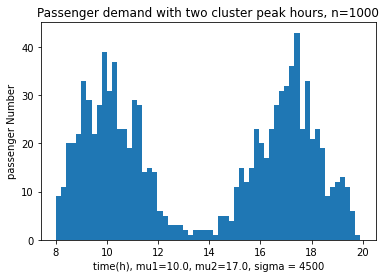

In [11]:
passenger_dist = passenger_demand(demand=1000, sigma = 4500, start = 8*3600, end=20*3600)
s1 = Simulation(passenger_dist, bus_start_interval = 5, gen_bus_interval = 20)
s1.print_settings()
s1.run() 

In [12]:
from itertools import chain

class Measure:
    def __init__(self, simulator):
        self.simulator = simulator
        
        self.passengers = []
        self.average_wait_times = []
        self.travel_times = []

        self.total_bus = list(chain(*[r.bus_list for r in self.simulator.route_list]))
        self.station_passengers =  list(chain(*[s.passengers for s in self.simulator.bus_stations]))
        self.bus_passengers =  list(chain(*[b.passengers for b in self.total_bus]))
        self.walk_passengers = self.simulator.walk_list
        self.arrival_passengers = self.simulator.arrivals
        
        self.passengers = self.total_passenger()
        
        
    def total_passenger(self):
        total_pass = [] 
        total_pass.extend(self.station_passengers)
        total_pass.extend(self.bus_passengers )
        total_pass.extend(self.walk_passengers) 
        total_pass.extend(self.arrival_passengers)
        
        #print('There are total {} passengers in simulation, {} choose to walk'
        #      ', {} took bus and arrived, {} still on bus, {} still waiting at station'.format(
        #      len(total_pass), 
        #      len(self.walk_passengers), 
        #      len(self.arrival_passengers),
        #      len(self.bus_passengers),
        #      len(self.station_passengers)
        #      ))
        return total_pass
    
    def travel_time(self):
        return [p.travel_time() for p in self.arrival_passengers]
        
    def avg_travel_time(self):
        return int(np.mean(self.travel_time()))
    
    def wait_time(self):
        return [p.time_waited_for_bus for p in self.passengers]
    
    def avg_wait_time(self):
        return int(np.mean(self.wait_time()))
    
    
m1 = Measure(s1)
#average travel time(arrived) and average waited time for all passengers. 
print(m1.avg_travel_time(), m1.avg_wait_time())


2357 1168


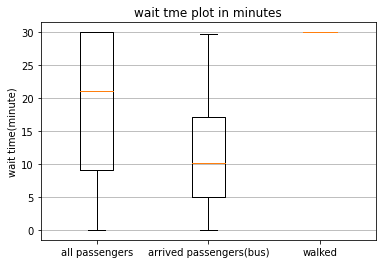

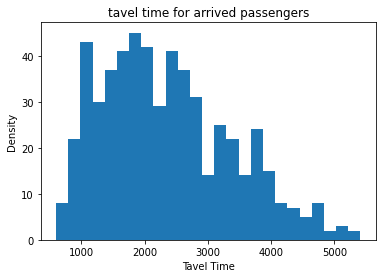

In [13]:
m1 = Measure(s1)
wait_time_all = np.array([p.time_waited_for_bus for p in m1.passengers])
wait_time_all = np.divide(wait_time_all,60)

wait_time_arrival = np.array([p.time_waited_for_bus for p in m1.arrival_passengers])
wait_time_arrival = np.divide(wait_time_arrival,60)

wait_time_walk = np.array([p.time_waited_for_bus for p in m1.walk_passengers])
wait_time_walk = np.divide(wait_time_walk,60)

labels = ['all passengers', 'arrived passengers(bus)', 'walked']
data = [wait_time_all,  wait_time_arrival, wait_time_walk]

fig1, ax1 = plt.subplots()
ax1.set_title('wait tme plot in minutes')
ax1.set_xticklabels(labels)
ax1.set_ylabel('wait time(minute)')
ax1.grid(axis='y')
ax1.boxplot(data)

plt.show()

def plot_travel_time_arrived_passengers(m1):
    """Plot the total travel_time for each passengers"""
    plt.hist(m1.travel_time(),
             bins=int(len(np.unique(m1.travel_time()))/20))
    plt.title('tavel time for arrived passengers')
    plt.xlabel('Tavel Time')
    plt.ylabel('Density')
    
plot_travel_time_arrived_passengers(m1)

# Multiple time simulation


In [14]:
#suppress sysout to save memory
class Suppress:
    """
    suppress/hide system output/ print in the favor of saving computation power.
    
    """
    def __init__(self, *, suppress_stdout=False, suppress_stderr=False):
        self.suppress_stdout = suppress_stdout
        self.suppress_stderr = suppress_stderr
        self.original_stdout = None
        self.original_stderr = None

    def __enter__(self):
        import sys, os
        devnull = open(os.devnull, "w")

        # Suppress streams
        if self.suppress_stdout:
            self.original_stdout = sys.stdout
            sys.stdout = devnull

        if self.suppress_stderr:
            self.original_stderr = sys.stderr
            sys.stderr = devnull

    def __exit__(self, *args, **kwargs):
        import sys
        # Restore streams
        if self.suppress_stdout:
            sys.stdout = self.original_stdout

        if self.suppress_stderr:
            sys.stderr = self.original_stderr
            
            
            
            
def simulation_and_measure(sigma, gen_bus_interval):
    """
    Simulation and measure function for multple time simuations.
    """
    avg_tt = 0
    avt_wt = 0
    passenger_dist = passenger_demand_noplot(demand=1000, sigma = sigma, start = 8*3600, end=20*3600)
    with Suppress(suppress_stdout=True): #suppress print
        sim = Simulation(passenger_dist, bus_start_interval=5, gen_bus_interval = gen_bus_interval)
        sim.run()
        m = Measure(sim)
    
    avg_tt = m.avg_travel_time()
    avt_wt = m.avg_wait_time()

    tmp = [sigma, gen_bus_interval, avg_tt, avt_wt]
    return tmp
    
    
def show_pairs(sigma, gen_bus_interval):
    print(sigma, gen_bus_interval)
    return [sigma, gen_bus_interval] 



# Warning!
## this box would run the simulation multiple times(default = 105*10)
iteration time depends on the number of combination number =( len(sigma_list) * len(interval_list)),
and interation parameter: $interations

The results are saved in a file "multi-simuation.npy"

In [15]:
#surpass system prints
#
if __name__ == '__main__':
    """
    Simulation with two variables: 
    1. standard deviation 'sigma' of passenger generation gussian distribution.
    2. bus geneartion interval 'interval'.
    
    Sigma determines the variance of passenger arrival time, the bigger the sigma,
    the shorter the guassian hat, the wider the distributions(two guassian stacked 
    together).
    
    The initial bus generation interveal is a time limitation between buses in
    same route.  
    
    ----------------------
    This section is utilized with multiple-processings provided by Python, all 
    ‘p’ threads run at same time, the choice of 'p' is depends on your machine's
    computation power. Choose a sutiable value for p = Pool(*) accordingly. 
    
    ----------------------
    The results is a m*n*4 array. m denotes to the iteration number, n denotes to
    the number of combinations, 4 are four fields including sigma, 
    gen_bus_interval, average travel time and average waited time for all 
    passengers in each simulation.
    
    *Note: rerun this procedure would probably override the saved results. 
    
    """
    from itertools import product
    
    #passgener guassian standarded deviation range from 3500 to 5000, increase by 100 each time
    sigma_list = list(range(3500, 5000, 100)) 
    #interval limitation between buses to take off, from 3 minuate to 10, increase by 1 minuate
    interval_list = list(range(5, 30, 5))
    combinations = [c for c in product(sigma_list, interval_list)]
    combination_nb = len(combinations)
    print(f"sigma and bus intervarl with total {combination_nb} sets.")
    
    from multiprocessing import Pool
 
    results = []
    interations = 10 #how many interations to run
    print(f"the simulation would run {interations*combination_nb} times.")
    
    p1 = Pool(40) # how many cores to run, depends on your computer power
    for i in range(interations):
        results.append(p1.starmap_async(simulation_and_measure, product(sigma_list, interval_list)))
    p1.close()
    result = np.array([p.get() for p in results])
    print(result.shape)
    np.save("multi-simulation", result)

sigma and bus intervarl with total 75 sets.
the simulation would run 750 times.
(10, 75, 4)


# Multiple time simulation data analysis(passenger = 1000)

In [11]:
data = np.load("multi-simulation.npy")
print(data.shape)
data = data.reshape((data.shape[0]*data.shape[1],4))
print(data.shape)
import pandas as pd

df = pd.DataFrame(data, columns = ['sigma', 'interval', 'TTmean', 'WTmean'])
df.head()

(10, 75, 4)
(750, 4)


sigma  interval  TTmean  WTmean
0   3500         5    2279    1380
1   3500        10    2395    1344
2   3500        15    2311    1208
3   3500        20    2288    1201
4   3500        25    2371    1155

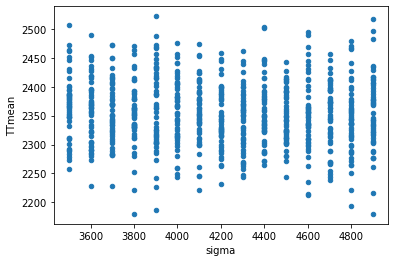

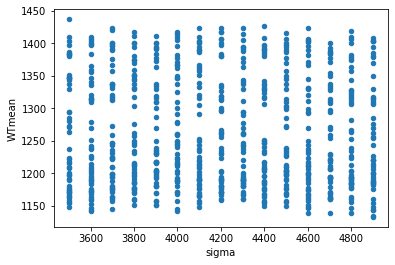

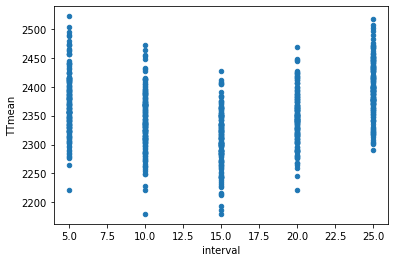

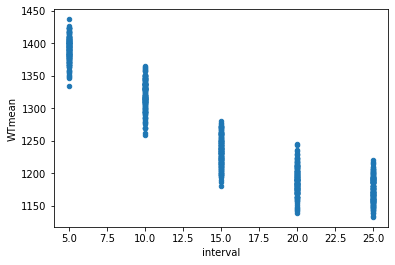

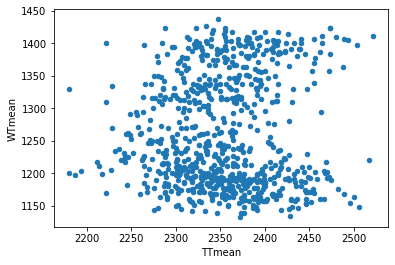

In [12]:
df.plot(kind = 'scatter', x = 'sigma', y ='TTmean')
df.plot(kind = 'scatter', x = 'sigma', y ='WTmean')

df.plot(kind = 'scatter', x = 'interval', y ='TTmean')
df.plot(kind = 'scatter', x = 'interval', y ='WTmean')

df.plot(kind = 'scatter', x = 'TTmean', y ='WTmean')

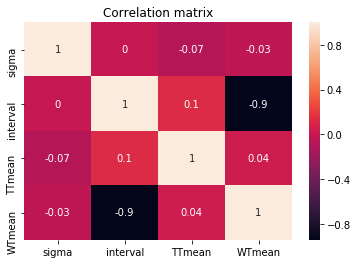

In [49]:
import seaborn as sns

"""calculate correlation matrix"""
fig2, ax2 = plt.subplots()

corrMatrix = df.corr()

sns.heatmap(corrMatrix, annot=True, fmt='.1g')
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_title("Correlation matrix")
plt.show()